In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

In [2]:
#Define the number of elememts in each set I, J, K
i_num = 5
k_num = 3
j_num = 5 #Without I and K, so real j_num_real = j_num + i_num + k_num

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])


In [3]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 100), 4)
    I.loc[i, 'Longtitude'] = round(random.uniform(0, 100), 4)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 100), 4)
    K.loc[k, 'Longtitude'] = round(random.uniform(0, 100), 4)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 100), 4)
    J.loc[j, 'Longtitude'] = round(random.uniform(0, 100), 4)

J.index = J['Point number'] 
#J = pd.concat([J, K], axis = 0) #Include K to J
I

,Point number,Latitude,Longtitude
Point number,,,
i0,i0,84.3875,34.899
i1,i1,55.0026,34.1115
i2,i2,10.235,46.9223
i3,i3,73.2285,64.8592
i4,i4,85.2221,38.2271


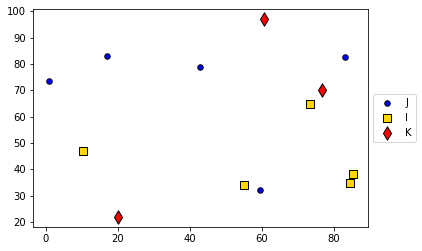

In [4]:
plt.scatter(J['Latitude'], J['Longtitude'], color = 'blue', edgecolors = 'black',
            marker = 'o', s = 30, label = 'J')
plt.scatter(I['Latitude'], I['Longtitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 50, label = 'I')
plt.scatter(K['Latitude'], K['Longtitude'], color = 'red', edgecolors = 'black',
            marker = 'd', s = 90, label = 'K')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [5]:
#Define constants

B = 100
S = 50
alpha = 10000
beta = 400000
q = {j: 100 for j in J.index}
theta = {i: random.randint(0, 50) for i in I.index}
p = 0.97

theta

{'i0': 26, 'i1': 41, 'i2': 31, 'i3': 31, 'i4': 11}

In [6]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longtitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longtitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_IK


{('i0', 'k0'): 36.168411096148525,
 ('i0', 'k1'): 65.737167812205,
 ('i0', 'k2'): 66.42911371650234,
 ('i1', 'k0'): 42.00729826351606,
 ('i1', 'k1'): 37.10643047518853,
 ('i1', 'k2'): 63.084976361254185,
 ('i2', 'k0'): 70.23908300796644,
 ('i2', 'k1'): 26.74008910923821,
 ('i2', 'k2'): 71.02080259262071,
 ('i3', 'k0'): 6.2643377000286256,
 ('i3', 'k1'): 68.39419945470522,
 ('i3', 'k2'): 34.46064508101959,
 ('i4', 'k0'): 33.1379797195001,
 ('i4', 'k1'): 67.27998218222119,
 ('i4', 'k2'): 63.649366161887265}

In [7]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k1', 'j3'),
 ('k2', 'j1'),
 ('k2', 'j2'),
 ('k2', 'j4')]

In [8]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []
  
M_kj  

{('k0', 'j2'): ['i3'],
 ('k0', 'j3'): ['i1', 'i3'],
 ('k0', 'j4'): ['i0', 'i3', 'i4'],
 ('k1', 'j3'): ['i1'],
 ('k2', 'j1'): [],
 ('k2', 'j2'): ['i3'],
 ('k2', 'j4'): ['i3']}

In [9]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i

{'i0': [('k0', 'j4')],
 'i1': [('k0', 'j3'), ('k1', 'j3')],
 'i2': [],
 'i3': [('k0', 'j2'), ('k0', 'j3'), ('k0', 'j4'), ('k2', 'j2'), ('k2', 'j4')],
 'i4': [('k0', 'j4')]}

In [10]:
model1 = gp.Model('Location-allocation problem 1')

Restricted license - for non-production use only - expires 2024-10-28


In [11]:
x_ikj = model1.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model1.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [12]:
model1.addConstrs(gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta[i] for i in I.index)

{'i0': <gurobi.Constr *Awaiting Model Update*>,
 'i1': <gurobi.Constr *Awaiting Model Update*>,
 'i2': <gurobi.Constr *Awaiting Model Update*>,
 'i3': <gurobi.Constr *Awaiting Model Update*>,
 'i4': <gurobi.Constr *Awaiting Model Update*>}